# Algorithm #2

## Library Imports

In [1]:
import numpy as np 
import cv2
from skimage.color import rgb2ycbcr, ycbcr2rgb
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.signal import convolve2d
from os import listdir
from tqdm import tqdm

## Feature Sign Algorithm for Quadratic Programming

In [2]:
#Aims to solve the Quadratic Programming Problem:
## ||y - Ax||^2 + lamb ||x||_1
def featureSign(y: np.ndarray, A: np.ndarray, lamb):
    EPS = 1e-9 #epsilon for comparisons
    
    x = np.zeros((A.shape[1], 1)) #initialize x
    theta = np.sign(x) #initialize theta
    y = y.reshape((-1, 1)) #reshape y to a column vector for ease of calculations
    gradient = (2 * (A.T @ A @ x)) - (2 * (A.T @ y))  #initial value of gradient 
    active_set = np.zeros(shape = x.shape) #initialize active set
    
    #Iterate
    for _ in range(10):
        #Select location of maximum absolute value of gradient. Denote this location as i
        gradient_max_idx = np.argmax(np.abs(gradient) * (x == 0))
        
        #Get ith column of A
        Ai = A[:, gradient_max_idx].flatten().reshape((-1, 1))
        
        #Activate x_i if it meets following conditions
        if gradient[gradient_max_idx] > lamb + EPS:
            x[gradient_max_idx] = (lamb - gradient[gradient_max_idx]) / (2 * (np.linalg.norm(Ai) ** 2))
            theta[gradient_max_idx] = -1
            active_set[gradient_max_idx] = 1
        elif gradient[gradient_max_idx] < -lamb - EPS:
            x[gradient_max_idx] = (-lamb - gradient[gradient_max_idx]) / (2 * (np.linalg.norm(Ai) ** 2))
            theta[gradient_max_idx] = 1
            active_set[gradient_max_idx] = 1
        else:
            if np.all(x == 0):
                break
        
        #Feature-Sign Step
        for _ in range(10):
            x_non_zero_idxes = (x != 0).flatten() #non zero indices in x
            A_hat = A[:, x_non_zero_idxes] #columns of A corresponding to non zero indices of X
            x_hat = x[x_non_zero_idxes, :] #only extract non zero indices of x
            theta_hat = theta[x_non_zero_idxes, :] #elements of theta that correspond to non zero indices of X
            
            #Solve for optimal x_hat of the function ||y - A_hat x_hat||^2 + y theta_hat^T x_hat
            x_hat_new = np.linalg.lstsq(A_hat.T @ A_hat, A_hat.T @ y - 0.5 * lamb * theta_hat, rcond=None)[0]            
            loss_new = np.linalg.norm(y - A_hat @ x_hat_new) ** 2 + lamb * np.sum(abs(x_hat_new))
            
            #Find indices where sign changes
            idx_hats = np.where(x_hat * x_hat_new < 0) [0]
            
            #If we have no sign changes just go with x_hat_new
            if np.all(idx_hats == 0):
                x_hat = x_hat_new
                x[x_non_zero_idxes, :] = x_hat
                theta = np.sign(x)
                active_set = (x != 0)
                
            else:
                #Perform discrete line search from x_hat to x_hat_new
                x_min = x_hat_new
                loss_min = loss_new
                diff = x_min - x_hat
                delta = diff / x_hat
                
                #For each index where sign changes, let's evaluate it at the point where the index is 0
                for zd in idx_hats.T:
                    x_s = x_hat + (diff/np.abs(delta[zd]))
                    x_s[zd] = 0
                    x_s_idx = (x_s != 0).flatten()
                    
                    #Get modified A and x
                    A_hat_s_idx = A_hat[:, x_s_idx]
                    x_s_modified = x_s[x_s_idx, :]
                    
                    #Solve for loss
                    loss = np.linalg.norm(y - A_hat_s_idx @ x_s_modified) ** 2 + lamb * np.sum(abs(x_s_modified))
                    if loss < loss_min:
                        x_min = x_s
                        loss_min = loss
                
                #Re-set x, theta, and active_set
                x[x_non_zero_idxes, :] = x_min
                theta = np.sign(x)
                active_set = (x != 0)     
            
            #Given gradient, check for optimality conditions
            gradient = (2 * (A.T @ A @ x)) - (2 * (A.T @ y))
            
            #Get non-zero indices
            non_zero_idxs = (x != 0).flatten()
            if np.all(gradient[non_zero_idxs, :] + lamb * theta[non_zero_idxs, :] == 0):
                break
            
        #Get zero indices
        zero_idxs = (x == 0).flatten()
        if np.all(gradient[zero_idxs, :] <= lamb):
            break
                    
    return x

## Super Resolution Algorithm

This algorithm will be finding the sparsest representation of patches from the low-resolution image. The optimization problem that this algorithm will be solving is $min ||\alpha||_1  \;\; s.t. \;\;  ||FD_l\alpha -Fy||_2^2 \leq \epsilon_1 \;\; , \;\; ||PD_h\alpha - w||_2^2 \leq \epsilon_2$. In this optimization problem $F$ is the linear feature extration operator which represents how closely $\alpha$ should represent $y$. $D$ represents the low-resolution and high-resolution dictionaries. $P$ and $w$ will indicate the region of overlap between the current patch and the previously reconstructed patch. 

The objective of this algorithm will be to reconstruct the high-resolution image by first finding a sparse representation of the patches from the low-resolution image, then applying the sparse coefficients to the high-resolution dictionary to construct the high resolution image. 

In [3]:
#Compute Features using First and Second Order Gradient Filters
def F(img_lr: np.ndarray):
    h, w = img_lr.shape
    img_lr_feat = np.zeros((h, w, 4))

    # First order gradient filters
    hf1 = [[-1, 0, 1], ] * 3
    vf1 = np.transpose(hf1)

    img_lr_feat[:, :, 0] = convolve2d(img_lr, hf1, 'same')
    img_lr_feat[:, :, 1] = convolve2d(img_lr, vf1, 'same')

    # Second order gradient filters
    hf2 = [[1, 0, -2, 0, 1], ] * 3
    vf2 = np.transpose(hf2)

    img_lr_feat[:, :, 2] = convolve2d(img_lr, hf2, 'same')
    img_lr_feat[:, :, 3] = convolve2d(img_lr, vf2, 'same')
    
    #Compute Low Resolution Image Features
    return img_lr_feat

#Given a High Resolution Image and the Norm of the Upscaled Low Resolution Image, ensure that the High Resolution Image Norm is 1.2 * Norm of Upscaled Low Resolution Image
def lin_scale(hIm, upscaled_norm):
    hr_norm = np.linalg.norm(hIm)
    if hr_norm > 0:
        hIm *= (upscaled_norm * 1.2 / hr_norm)
    return hIm

#Conduct Super Resolution
#img_lr_y: Y component of Y-Cb-Cr Low Resolution Image
#size: size that we want to upsample img_lr_y to
#Dh: High Resolution Dictionary
#Dl: Low Resolution Dictionary
#lmbd: lambda for Feature Sign Algorithm
#overlap: how much we want patches to overlap during insertion phase
def SR(img_lr_y, size, Dh, Dl, lmbd, overlap):
    patch_size = 5

    #Upsample the low resolution image
    uIm = resize(img_lr_y, size)
    uIm_height, uIm_width = uIm.shape
    
    #Initialize the high resolution image
    hIm = np.zeros(uIm.shape)
    
    #count the number of times each pixel is included in patches
    counts = np.zeros(uIm.shape)

    #Extract first order and second order gradients from the upscaled, low resolution image
    img_lr_y_feat = F(uIm)

    #Create a grid over which we can obtain all the patches
    patch_grid_X = np.append(np.arange(0, uIm_width - patch_size - 1, patch_size - overlap), uIm_width - patch_size - 1)
    patch_grid_Y = np.append(np.arange(0, uIm_height - patch_size - 1, patch_size - overlap), uIm_height - patch_size - 1)

    #Iterate over each point in the grid
    for m in tqdm(range(0, len(patch_grid_X))):
        for n in range(0, len(patch_grid_Y)):
            patch_x_start = int(patch_grid_X[m])
            patch_y_start = int(patch_grid_Y[n])

            #Get Upsampled patch from the Low Res Image
            uIm_patch = uIm[patch_y_start : patch_y_start + patch_size, patch_x_start : patch_x_start + patch_size]
            uIm_mean = np.mean(uIm_patch)
            uIm_patch = uIm_patch.flatten(order='F') - uIm_mean
            uIm_norm = np.linalg.norm(uIm_patch)

            #Get Feature Patch from Gradient Patch
            feature_patch = img_lr_y_feat[patch_y_start : patch_y_start + patch_size, patch_x_start : patch_x_start + patch_size, :]
            feature_patch = feature_patch.flatten(order='F')
            feature_norm = np.linalg.norm(feature_patch)
            
            #Normalize Feature Patch if needed
            if feature_norm > 1:
                y = feature_patch / feature_norm
            else:
                y = feature_patch
            
            #Run Feature Sign for Quadratic Programming to get alpha
            alpha = featureSign(y, Dl, lmbd)

            #Get High Resolution Patch
            hIm_patch = Dh @ alpha
            
            #Scale the Norm of the High Resolution Patch
            hIm_patch = lin_scale(hIm_patch, uIm_norm)

            #Reshape Patch and Add Mean
            hIm_patch = np.reshape(hIm_patch, (patch_size, -1))
            hIm_patch += uIm_mean

            #Store Patch and Append Count for Appropriate Pixels
            hIm[patch_y_start : patch_y_start + patch_size, patch_x_start : patch_x_start + patch_size] += hIm_patch
            counts[patch_y_start : patch_y_start + patch_size, patch_x_start : patch_x_start + patch_size] += 1

    #Divide High Resolution Image by Count Matrix
    index = np.where(counts < 1)[0]
    hIm[index] = uIm[index]
    counts[index] = 1
    hIm = hIm / counts
    return hIm

## Backprojection Algorithm

The sparse representation optimization algorithm does not require the sparse representations to match the low-resolution patches too closely. Therefore, this algorithm aims to correct this error by projecting the result of the previous algorithm to the solution space based on the reconstruction constraint. The reconstruction constraint is as defined: $Y = SHX$ where $S$ represents the downsampling operation, $H$ represents the blurring filter, and $X,Y$ represent the high-resolution and low-resolution image respectively. 

The optimization problem this algorithm will be solving $X^* = arg min_X ||SHX - Y||_2^2 + x ||X - X_0||_2^2$. This optimization ensures that the finished product does not stray too far from the original low-resolution image. It achieves this by treating the low-resolution image as a result of downsampling and blurring operations. 

In [4]:
#Generate a Gaussian Kernel for 2D Convolution
#kernel_shape: shape of kernel
#std_dev: standard deviation of kernel
def gauss2D(kernel_shape, std_dev):
    #Get Lengths from Center for Gaussian Kernel
    m,n = [(dim-1.)/2. for dim in kernel_shape] 
    
    #Generate Meshgrid for Gaussian Kernel Generation
    y,x = np.ogrid[-m:m+1,-n:n+1]
    
    #Generate Normal Distribution Values Across gaussian Kernel
    gaussian_distribution = np.exp( -(x*x + y*y) / (2.*std_dev*std_dev) )
    
    #For values of the distribution less than machine precision, set to 0
    gaussian_distribution[ gaussian_distribution < np.finfo(gaussian_distribution.dtype).eps*gaussian_distribution.max() ] = 0
    
    #Normalize Distribution to Sum to 1
    distribution_sum = gaussian_distribution.sum()
    if distribution_sum != 0:
        gaussian_distribution /= distribution_sum
    
    return gaussian_distribution

#Run the Backprojection Part of the Algorithm
#U: U matrix
#lIm: Low Resolution Image
def backprojection(U, lIm, maxIter):
    p = gauss2D((5, 5), 1)
    p = (p * p) / (np.sum(p))
    
    #Get shape of U and intialize c
    n, r = U.shape
    c = np.abs(np.random.normal(size = (r, n)))

    for _ in range(maxIter):
        hIm = U @ c
        img_lr_ds = resize(hIm, lIm.shape, anti_aliasing=1)
        img_diff = lIm - img_lr_ds
        img_diff = resize(img_diff, hIm.shape)
        c += U.T @ convolve2d(img_diff, p, 'same')
    
    hIm = U @ c
    return hIm

## NMF

In [5]:
#Non-Negative Matrix Factorization
#X: Input Array
def NMF(X: np.ndarray, iterations = 1000):
    n, m = X.shape
    
    r = int((n * m) / (n + m))
    
    U = np.abs(np.random.normal(size = (n, r)))
    V = np.abs(np.random.normal(size = (r, m)))
    
    for iter in range(iterations):
        DeltaV = ((U.T @ X) / (U.T @ U @ V))
        DeltaU = ((X @ V.T) / (U @ V @ V.T))
        
        V *= DeltaV
        U *= DeltaU
        
        print(f"Finished Iteration {iter + 1}")
    
    return U

#Conduct Non-Negative Matrix Factorization
img_path = '../Data/Training/face.jpg'
X = cv2.imread(img_path)
X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)

X = rgb2ycbcr(X) #Get Convert RGB to Y, CB, Cr for Low Resolution Image
X = X[:, :, 0] #Y Component

A = NMF(X) #Get NMF of X

#Perform QR Decomposition to get orthonormal columns
U, R = np.linalg.qr(A)
np.save("U.npy", U)

Finished Iteration 1
Finished Iteration 2
Finished Iteration 3
Finished Iteration 4
Finished Iteration 5
Finished Iteration 6
Finished Iteration 7
Finished Iteration 8
Finished Iteration 9
Finished Iteration 10
Finished Iteration 11
Finished Iteration 12
Finished Iteration 13
Finished Iteration 14
Finished Iteration 15
Finished Iteration 16
Finished Iteration 17
Finished Iteration 18
Finished Iteration 19
Finished Iteration 20
Finished Iteration 21
Finished Iteration 22
Finished Iteration 23
Finished Iteration 24
Finished Iteration 25
Finished Iteration 26
Finished Iteration 27
Finished Iteration 28
Finished Iteration 29
Finished Iteration 30
Finished Iteration 31
Finished Iteration 32
Finished Iteration 33
Finished Iteration 34
Finished Iteration 35
Finished Iteration 36
Finished Iteration 37
Finished Iteration 38
Finished Iteration 39
Finished Iteration 40
Finished Iteration 41
Finished Iteration 42
Finished Iteration 43
Finished Iteration 44
Finished Iteration 45
Finished Iteration 

## Rescale

In [6]:
### was used to generate train/test images just for playing around
# # Set train and val HR and LR paths
# test_path = '../Data/Testing/'

# numTestImages = len(listdir(test_path))
# upscale = 4.0

# for i in tqdm(range(numTestImages)):
#     img_name = listdir(test_path)[i]
    
#     if 'ICChip_gnd' in img_name:
#         lr_name = img_name.replace("_gnd", "")
#         hIm = cv2.imread('{}{}'.format(test_path, img_name))
#         new_img = cv2.resize(hIm, tuple(int(x * (1/upscale)) for x in hIm.shape)[-2::-1], interpolation = cv2.INTER_NEAREST)
#         cv2.imwrite('{}{}'.format(test_path, lr_name), new_img)
#         print(lr_name)

## Execution

0.5901584788439682 -0.7218964802749671


100%|██████████| 128/128 [45:08<00:00, 21.16s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


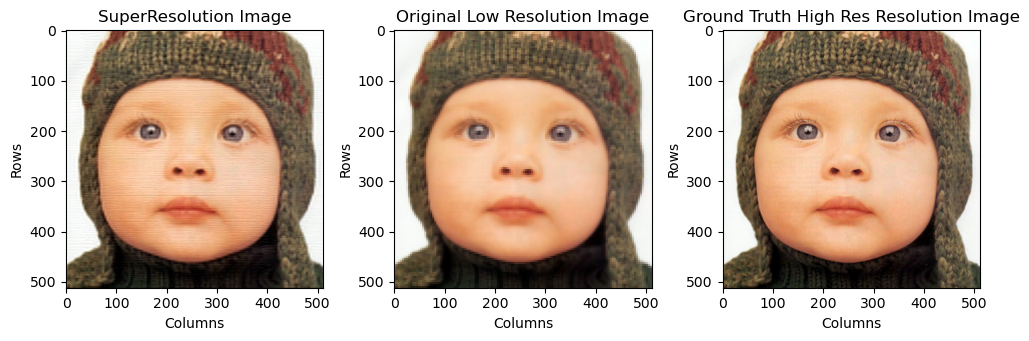

In [7]:
#Get U. Replace the None with something Later
U = np.load("U.npy")
print(np.max(U), np.min(U))

# Set which dictionary you want to use    
Dh = np.load("../Dictionaries/Dh.npy")
Dl = np.load("../Dictionaries/Dl.npy")

#normalize the dictionaries
Dh = normalize(Dh)
Dl = normalize(Dl)

### SET PARAMETERS
lmbd = 0.1 #lambda for sparsity
patch_size= 5 #patch size that we extract from images
D_size = 512 #dictionary size

overlap = 1 #overlap when we iterate through patches
lmbd = 0.1 #lambda for sparsity
maxIter = 100 #maximum number of iterations for backprojection

#Get Low and High Resolution Images
lr_image_path = "../Data/Testing/Child.png"
hr_image_path = "../Data/Testing/Child_gnd.bmp"

#Read Low Resolution Image. Cv2 reads in BGR order so must be flipped! 
lIm = cv2.imread(lr_image_path)
img_lr_ori = lIm #store original low resolution image
lIm = cv2.cvtColor(lIm, cv2.COLOR_BGR2RGB)

# Read and save ground truth image[High Resolution Image]
img_hr = cv2.imread(hr_image_path)
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)

# Change color space for Low Res and High Res Image
img_hr_y = rgb2ycbcr(img_hr)[:, :, 0] #Get Convert RGB to Y, CB, Cr and get Y component for High Resolution Image

lIm = rgb2ycbcr(lIm) #Get Convert RGB to Y, CB, Cr for Low Resolution Image
img_lr_y = lIm[:, :, 0] #Y Component
img_lr_cb = lIm[:, :, 1] #CB Component
img_lr_cr = lIm[:, :, 2] #Cr Component

# Upscale chrominance to color SR images
img_sr_cb = resize(img_lr_cb, (img_hr.shape[0], img_hr.shape[1]), order=0)
img_sr_cr = resize(img_lr_cr, (img_hr.shape[0], img_hr.shape[1]), order=0)

# Super Resolution via Sparse Representation
img_sr_y = backprojection(U, img_lr_y, maxIter)
img_sr_y = SR(img_sr_y, img_hr_y.shape, Dh, Dl, lmbd, overlap)
    
# Create colored SR images
hIm = np.stack((img_sr_y, img_sr_cb, img_sr_cr), axis=2)
hIm = ycbcr2rgb(hIm)

#Plot Images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(hIm)
axes[0].set_title('SuperResolution Image')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Rows')

axes[1].imshow(resize(cv2.cvtColor(img_lr_ori, cv2.COLOR_BGR2RGB), (img_hr.shape[0], img_hr.shape[1]), order = 0), cmap='gray')
axes[1].set_title('Original Low Resolution Image')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Rows')


axes[2].imshow(img_hr, cmap='gray')
axes[2].set_title('Ground Truth High Res Resolution Image')
axes[2].set_xlabel('Columns')
axes[2].set_ylabel('Rows')

plt.tight_layout()
plt.show()

Similar to algorithm 1, the super-resolution image has more sharpness and detail compared to the original low-resolution image. A difference in the image results from this algorithm and the previous one is that the resulting super-resolution image has horizontal artifacts throughout the image. From our testing, these artifacts can be reduced by increasing the number of iteration used to train matrix $U$. 